In [2]:
#import required packages
import pandas as pd
import numpy as np

import re
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

C:\Users\ajesh\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional,Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub

In [4]:
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import multiprocessing
from gensim.utils import tokenize

In [5]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

In [6]:
from PIL import Image
import numpy as np

Pre-trained Word2Vec embedding

In [7]:
WordEmbedding=gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)

In [8]:
print('Vector Dimension:',WordEmbedding['Abuse'].shape[0])
WordEmbedding['Abuse']

Vector Dimension: 300


array([-0.14746094,  0.0032959 , -0.30859375,  0.12988281, -0.0324707 ,
        0.10205078, -0.06542969, -0.0534668 , -0.02600098,  0.34765625,
       -0.04614258,  0.12011719, -0.14550781,  0.36132812, -0.234375  ,
       -0.08496094,  0.04785156, -0.13574219, -0.18261719, -0.11474609,
        0.24023438,  0.109375  ,  0.484375  ,  0.03295898, -0.36914062,
       -0.31445312,  0.04736328, -0.0480957 ,  0.1015625 ,  0.02783203,
       -0.12890625, -0.26367188, -0.36523438, -0.45507812,  0.04638672,
       -0.2890625 , -0.39453125,  0.10058594, -0.02087402,  0.1796875 ,
       -0.10107422, -0.15820312, -0.23242188, -0.15820312, -0.20605469,
       -0.28710938, -0.06494141,  0.3203125 , -0.31835938,  0.21777344,
       -0.08007812, -0.04833984,  0.1640625 ,  0.2890625 ,  0.09472656,
        0.19628906, -0.39453125, -0.20117188, -0.11425781,  0.06884766,
       -0.19921875,  0.31445312,  0.23242188,  0.12890625,  0.17480469,
       -0.08935547, -0.25976562,  0.44335938,  0.08544922,  0.03

In [9]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ajesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
stop_words = set(stopwords.words('english'))
stop_words.add("br")
stop_words.add("wikipedia")
stop_words.add("url")

In [11]:
slang_dict=pd.read_csv('slangDict.csv')
slang_dict_map = dict(zip(slang_dict['slang'], slang_dict['word']))

# Function for replacing the slang words
def normalize_slang(text):
    return ' '.join([slang_dict_map[word] if word in slang_dict_map else word for word in text.split(' ')])

In [12]:
mask = np.array(Image.open("twitter_mask.png"))

In [68]:
train_data_bi=pd.read_csv('OffensiveBinaryDataset.csv')
test_data_bi = pd.read_csv('test.csv')
test_data_bi.drop(['id'],axis=1,inplace=True)

In [69]:
df_majority = train_data_bi[train_data_bi.label=="NOT"]
df_minority = train_data_bi[train_data_bi.label=="OFF"]

df_majority_downsampled = resample(df_majority,
                                  replace=False,
                                  n_samples=35000,
                                  random_state=123)

train_data_bi_new = pd.concat([df_majority_downsampled,df_minority])

In [15]:
# Function for replacing the slang words
def normalize_slang(text):
    return ' '.join([slang_dict_map[word] if word in slang_dict_map else word for word in text.split(' ')])

In [16]:
def lemmaWords(tweet):
    tweet_tokens = word_tokenize(tweet)
    lemmatizer = WordNetLemmatizer() # instatiate an object WordNetLemmatizer Class
    lemma_words = [lemmatizer.lemmatize(w,pos="v") for w in tweet_tokens]
    return " ".join(lemma_words) 

In [17]:
# Function for removing the @user/retweet, urls, slangs word conversion, lowercase conversion, special characters and numbers.
def text_cleaning(text):
    retweet_user = ['rt', 'user']
    if text:
        text = ' '.join(text.split('.'))
        text = re.sub('\/', ' ', text)
        text = re.sub(r'\\', ' ', text)
        text = re.sub(r'((www\.[^\s]+)|(http)\S+)', '',text)
        text = normalize_slang(text)
        for word in retweet_user:
            text = re.sub(word,'', text)
            text = re.sub(word.upper(),' ',text)
        #text = re.sub(r'\s+', ' ', re.sub('[^A-Za-z]', ' ', text.strip().lower())).strip()
        text = re.sub(r'\W+', ' ', text.strip().lower()).strip()
        text = re.sub(r"[0-9]", '', text)
        text = [word for word in text.split() if word not in stop_words]
        return text
    return []

In [18]:
def TextPreprocessing(df):
    df['tweets'] = df['tweets'].apply(lambda x: ' '.join(text_cleaning(x)))
    df['tweets'] = df['tweets'].apply(lemmaWords)
    df['tweet_length']=df['tweets'].apply(len)
    df['text_tokens']=df['tweets'].apply(lambda x: x.split())
    df['class_label']=np.where(df['label']== 'OFF', 1, 0)
    #removing the tweets more than 300 characters.
    longtweets_index_names = df[(df['tweet_length'] >= 300)].index
    df.drop(longtweets_index_names, inplace = True)
    return df
    
    

In [19]:
train_data= TextPreprocessing(train_data_bi_new)

In [170]:
np.array(train_data.iloc[:,4])

array([0, 0, 0, ..., 1, 1, 1])

In [20]:
def textPadding(sequence,maxlength):
    padded_sequence=pad_sequences(sequence, maxlen = maxlength,
                                padding = 'pre',
                                truncating='pre')
    return padded_sequence

In [21]:
def get_Word2Vec(embedding_matrix,tokenizer_items):
    skipped_words=0
    
    for word, index in tokenizer_items:
        try:
            embedding_vector=WordEmbedding[word]
            embedding_matrix[index]= embedding_vector
        except:
            skipped_words= skipped_words+1
            pass
       # if embedding_vector is not None:
            
            
    return embedding_matrix,skipped_words

In [34]:
def TextPreprocessing_FeatureExtraction(train_df,test_df):
    train_data= TextPreprocessing(train_df)
    test_data= TextPreprocessing(test_df)
    
    tokenizer = Tokenizer(num_words = 10000, oov_token='<oov>')
    tokenizer.fit_on_texts(train_data.text_tokens)
    vocab_size=len(tokenizer.word_index)+1
    
    #Splitting train and validation data
    train_X = train_data.iloc[:,3]
    train_Y=np.array(train_data.iloc[:,4])
    
    test_X = test_data.iloc[:,3]
    test_Y=np.array(test_data.iloc[:,4])
    
     
    #Prepairing token sequence for training and validation set
    traning_sequences = tokenizer.texts_to_sequences(train_X)
    test_sequences = tokenizer.texts_to_sequences(test_X)
    
    #Getting maximum number of words in text for padding
    maxlen = max([len(x) for x in np.array(traning_sequences)])
    
    #Applying padding for the shorter text
    training_padded = textPadding(traning_sequences,maxlen)
    test_padded = textPadding(test_sequences,maxlen)
    
    #Prepairing the embedding matrix for the dataset
    embedding_matrix=np.zeros((vocab_size,300))    
    embedding_matrix,skipped_words=get_Word2Vec(embedding_matrix,tokenizer.word_index.items())
    
    return training_padded,test_padded,train_Y,test_Y,vocab_size,maxlen,embedding_matrix
    

In [70]:
training_padded,test_padded,train_Y,test_Y,vocab_size,maxlen,embedding_matrix=TextPreprocessing_FeatureExtraction(train_data_bi,test_data_bi)

C:\Users\ajesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [64]:
training_padded.shape

(62706, 90)

In [71]:

model_bi_v3=Sequential()
model_bi_v3.add(Embedding(vocab_size,300,weights=[embedding_matrix], input_length=maxlen, trainable=False))
model_bi_v3.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5))
model_bi_v3.add(Dense(1,activation='sigmoid'))

In [72]:
model_bi_v3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [73]:
history_bi_v3 = model_bi_v3.fit(training_padded, train_Y, epochs=30,batch_size = 500, validation_split=0.2,verbose=1)

Epoch 1/30
101/101 [==============================] - 229s 2s/step - loss: 0.3501 - accuracy: 0.8465 - val_loss: 0.1553 - val_accuracy: 0.9695
Epoch 2/30
101/101 [==============================] - 233s 2s/step - loss: 0.2671 - accuracy: 0.8824 - val_loss: 0.0886 - val_accuracy: 0.9829
Epoch 3/30
101/101 [==============================] - 249s 2s/step - loss: 0.2525 - accuracy: 0.8900 - val_loss: 0.1229 - val_accuracy: 0.9643
Epoch 4/30
101/101 [==============================] - 253s 3s/step - loss: 0.2440 - accuracy: 0.8935 - val_loss: 0.0995 - val_accuracy: 0.9710
Epoch 5/30
101/101 [==============================] - 277s 3s/step - loss: 0.2382 - accuracy: 0.8964 - val_loss: 0.1137 - val_accuracy: 0.9696
Epoch 6/30
101/101 [==============================] - 274s 3s/step - loss: 0.2326 - accuracy: 0.8998 - val_loss: 0.0888 - val_accuracy: 0.9788
Epoch 7/30
101/101 [==============================] - 274s 3s/step - loss: 0.2301 - accuracy: 0.8989 - val_loss: 0.0582 - val_accuracy: 0.9872

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


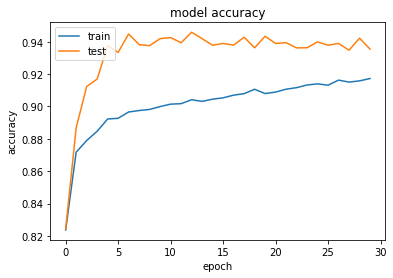

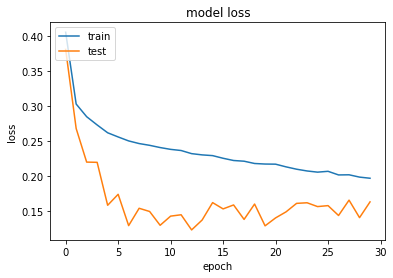

In [76]:
print(history_bi.history.keys())

# summarize history for accuracy
plt.plot(history_bi.history['accuracy'])
plt.plot(history_bi.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_bi.history['loss'])
plt.plot(history_bi.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [83]:
print(' Training and Validation accuracy: ',np.mean(history_bi_v3.history['accuracy']))

 Training and Validation accuracy:  0.9067093292872112


In [80]:
score = model_bi_v3.evaluate(test_padded, test_Y, verbose=1)

27/27 [==============================] - 1s 44ms/step - loss: 0.4304 - accuracy: 0.8093
